In [1]:
from collections import namedtuple
import glob
from itertools import islice
from operator import lt, gt

from astropy.coordinates import Angle, SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import corner
from ebltable.tau_from_model import OptDepth
import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18, 'figure.figsize': (14.0, 8.0)})
from numba import njit
import numpy as np
import pandas as pd
from scipy import integrate, interpolate, optimize, stats

In [2]:
# Read in the source selection catalog
whsp = pd.read_csv("2WHSP_catalog.txt", skiprows=4, delimiter=' *\| *', engine='python', na_filter=False)
# Drop dummy columns caused by extra delimiters
whsp.drop(whsp.columns[[0, -1]], axis=1, inplace=True)
# Munge flags into Boolean values
for col in whsp.columns:
    if col.endswith('_flag'):
        whsp[col].replace({':': True, '': False}, inplace=True)
    elif col.endswith('_limit'):
        whsp[col].replace({'&gt;': True, '': False}, inplace=True)
# Convert sexagesimal coordinates to decimal degrees
whsp['ra'] = Angle(whsp['ra'], unit='hourangle').to_value(u.degree)
whsp['dec'] = Angle(whsp['dec'], unit='deg').value
whsp

,name,ra,dec,lii,bii,source_flag,bzcat_object_type,log_nu_peak_limit,log_nu_peak,log_nu_peak_flag,...,log_nu_f_nu_flag,redshift_limit,redshift,redshift_flag,ref_redshift,fermi_lat_detection,gamma_ray_index,gamma_ray_index_error,twofhl_name,figure_of_merit
0,2WHSP J045823.5-864408,74.597917,-86.735556,299.6559,-28.6358,False,,False,16.0,True,...,True,False,,False,,,,,,0.10
1,2WHSP J211011.1-861847,317.546250,-86.313056,306.4041,-29.1836,False,,False,15.4,False,...,False,False,,False,,3FGL J2108.6-8619,1.74,0.26,2FHL J2112.5-861,0.20
2,2WHSP J153103.7-861225,232.765417,-86.206944,305.5986,-24.1936,False,,False,15.6,False,...,False,False,,False,,,,,,0.32
3,2WHSP J102634.3-854314,156.642917,-85.720556,300.1731,-23.6490,False,5BZB,False,15.0,False,...,False,False,,False,,3FGL J1026.4-8542,2.01,0.08,2FHL J1026.9-854,0.63
4,2WHSP J222610.9-840621,336.545417,-84.105833,307.0361,-31.8176,False,,False,16.1,False,...,False,False,,False,,,,,,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,2WHSP J041949.3+843835,64.955417,84.643056,127.5486,23.7625,False,,False,16.2,False,...,False,False,,False,,,,,,0.10
1687,2WHSP J214609.6+850148,326.540000,85.030000,119.0102,23.6419,False,,False,15.7,False,...,False,False,,False,,,,,,0.25
1688,2WHSP J074716.2+851207,116.817500,85.201944,128.2161,28.1864,False,,False,16.8,False,...,False,False,,False,,3FGL J0746.9+8511,1.79,0.12,,0.25
1689,2WHSP J104810.9+855957,162.045417,85.999167,125.3103,30.5442,False,,False,17.0,True,...,True,False,,False,,,,,,0.16


In [3]:
# Define sky selection cuts
def sky_selection_cuts(ra, dec, ra_bounds=None, dec_bounds=None, b_bounds=None):
    """Applies selection cuts on sky coordinates
    
    RA, Dec, and bounds should be specified in degrees.
    Bounds should be expressed as lists of bounds tuples:
        [(lower_bound_1, upper_bound_1), (lower_bound_2, upper_bound_2)...]
    """
    cut_mask = np.ones(len(ra), dtype=bool)
    print("{} sources total".format(len(cut_mask)))
    if ra_bounds:
        ra_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in ra_bounds:
            ra_mask |= (lower <= ra[cut_mask]) & (ra[cut_mask] <= upper)
        cut_mask[cut_mask] &= ra_mask
        print("{} sources left after RA cut".format(sum(cut_mask)))
    if dec_bounds:
        dec_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in dec_bounds:
            dec_mask |= (lower <= dec[cut_mask]) & (dec[cut_mask] <= upper)
        cut_mask[cut_mask] &= dec_mask
        print("{} sources left after declination cut".format(sum(cut_mask)))
    if b_bounds:
        b = SkyCoord(ra=ra[cut_mask], dec=dec[cut_mask], unit='deg').galactic.b.value
        b_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in b_bounds:
            b_mask |= (lower < b) & (b < upper)
        cut_mask[cut_mask] &= b_mask
        print("{} sources left after Galactic latitude cut".format(sum(cut_mask)))
    return cut_mask

In [4]:
# Apply selection cuts to 2WHSP catalog
#ra_bounds = [((6*u.hourangle).to_value(u.degree), (10*u.hourangle).to_value(u.degree))]
ra_bounds = [((0*u.hourangle).to_value(u.degree), (24*u.hourangle).to_value(u.degree))]
dec_bounds = [(1.7, 61.7)]
b_bounds = [(-np.inf, -10), (10, np.inf)]

cut_mask = sky_selection_cuts(whsp.ra, whsp.dec, ra_bounds=ra_bounds, dec_bounds=dec_bounds, b_bounds=b_bounds)
cut_mask[cut_mask] = whsp.figure_of_merit[cut_mask] > 1
print("{} sources left after Figure of Merit cut".format(sum(cut_mask)))

1691 sources total
1691 sources left after RA cut
787 sources left after declination cut
776 sources left after Galactic latitude cut
40 sources left after Figure of Merit cut


In [5]:
# Calculate sky coverage (taking into account sky selection cuts only)
# The effects of the RA and Dec cuts are determined analytically,
# but the effect of the Galactic latitude cut is found using a Monte Carlo method,
# since that coordinate is not orthogonal to the first two

num_points = 1000000
coords = np.random.random([num_points, 2])

ra_lo, ra_hi = ra_bounds[0]
ra_fraction = (ra_hi - ra_lo) / 360
print("Fraction kept after RA cut: {:.04}".format(ra_fraction))
ra = (ra_hi - ra_lo)*coords[:,0] + ra_lo

dec_lo, dec_hi = (np.pi/180)*np.array(dec_bounds[0])
dec_fraction = (np.sin(dec_hi) - np.sin(dec_lo)) / 2
print("Fraction kept after Dec cut: {:.04}".format(dec_fraction))
dec = 180/np.pi*np.arcsin(2*np.sin((dec_hi - dec_lo)/2)*np.cos((dec_hi + dec_lo)/2)*coords[:,1] + np.sin(dec_lo))

b_fraction = sum(sky_selection_cuts(ra, dec, b_bounds=b_bounds)) / num_points
print("Fraction kept after Galactic latitude cut: {:.04}".format(b_fraction))

sky_coverage_const = ra_fraction * dec_fraction * b_fraction
print("Sky coverage: {:.04}".format(sky_coverage_const))

Fraction kept after RA cut: 1.0
Fraction kept after Dec cut: 0.4254
1000000 sources total
820795 sources left after Galactic latitude cut
Fraction kept after Galactic latitude cut: 0.8208
Sky coverage: 0.3492


In [6]:
# Since we required 2WHSP FoM > 1 (as opposed to >= 1),
# determine the synchrotron flux limit using the flux of the weakest possibly detected source
# Don't take into account the other cuts, since the cuts are independent

min_log_nu_f_nu = np.min(whsp.log_nu_f_nu[whsp.figure_of_merit > 1].to_numpy())
min_nu_f_nu = (10**min_log_nu_f_nu)*u.erg/(u.cm*u.cm)/u.s
print("Minimum log(nu F_nu) is {}, giving {:.04}".format(min_log_nu_f_nu, min_nu_f_nu))

Minimum log(nu F_nu) is -12.2, giving 6.31e-13 erg / (cm2 s)


In [7]:
def logN_logS(fluxes, sky_coverage_const=1.0, label=None):
    nums = np.array(range(len(fluxes), 0, -1)) / sky_coverage_const / (4*np.pi*u.sr).to_value(u.degree*u.degree)
    plt.plot(np.sort(fluxes), nums, marker='x', linestyle='none', label=label)
    plt.xscale('log')
    plt.xlabel("S [erg cm^-2 s^-1]")
    plt.yscale('log')
    plt.ylabel("N(>S) [deg^-2]")
    plt.legend()

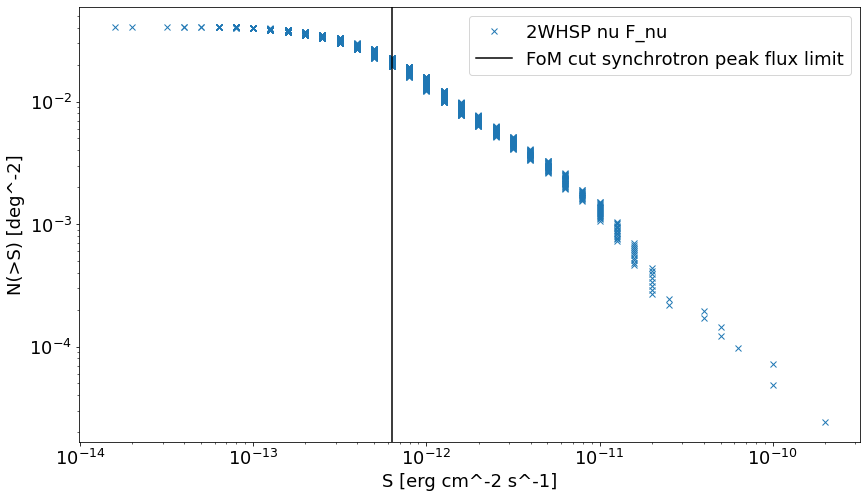

In [8]:
# Plot the logN-logS of the 2WHSP sources, to show that the slope is constant in the selection region
logN_logS(10**whsp.log_nu_f_nu, label="2WHSP nu F_nu")
plt.axvline(min_nu_f_nu.value, color='k', label="FoM cut synchrotron peak flux limit")
plt.legend()

In [9]:
# Read in our data and join in to the selected 2WHSP sources
vts_data = pd.read_csv("LF_blazar_data.csv")
raw_data = vts_data.join(whsp[cut_mask].set_index('name'), on='whsp_name', how='inner')

# Olivier calculated an average Mrk 501 flux of 23% Crab (it's listed as "variable" in TeVCat)
raw_data.loc[raw_data.source == "Mkn 501", 'tevcat_flux_crab'] = 0.23

raw_data

,source,whsp_name,z,archival_hours,year1_hours,legacy_hours,tevcat_flux_crab,tevcat_index,ra,dec,...,log_nu_f_nu_flag,redshift_limit,redshift,redshift_flag,ref_redshift,fermi_lat_detection,gamma_ray_index,gamma_ray_index_error,twofhl_name,figure_of_merit
0,RGB J0152+017,2WHSP J015239.5+014717,0.080,19.3,0.0,5,0.020,2.95,28.164583,1.788056,...,False,False,0.080,False,,3FGL J0152.6+0148,1.89,0.10,2FHL J0152.8+014,1.26
1,B3 0133+388,2WHSP J013632.5+390558,NaN,18.5,0.0,5,NaN,NaN,24.135417,39.099444,...,False,False,,False,,3FGL J0136.5+3905,1.70,0.02,2FHL J0136.5+390,2.51
2,1ES 0120+340,2WHSP J012308.5+342048,0.270,11.1,5.0,8,NaN,NaN,20.785417,34.346667,...,False,False,0.270,False,,3FGL J0122.8+3423,1.48,0.14,,3.16
3,RGB J0045+214,2WHSP J004519.2+212739,NaN,0.9,3.5,10,NaN,NaN,11.330000,21.460833,...,False,False,,False,,3FGL J0045.3+2126,1.90,0.05,2FHL J0045.2+212,1.26
4,1ES 0229+200,2WHSP J023248.5+201717,0.139,198.6,18.0,0,0.018,2.50,38.202083,20.288056,...,False,False,0.139,False,,3FGL J0232.8+2016,2.03,0.14,,2.00
5,RGB J0321+236,2WHSP J032159.8+233611,NaN,10.6,4.0,8,NaN,NaN,50.499167,23.603056,...,False,False,,False,,3FGL J0322.0+2335,1.95,0.07,2FHL J0322.0+233,1.26
6,1FGL J0333.7+2919,2WHSP J033349.0+291631,NaN,3.3,7.9,10,NaN,NaN,53.454167,29.275278,...,False,False,,False,,3FGL J0333.6+2916,1.86,0.06,2FHL J0333.7+291,1.26
7,RGB J0316+090,2WHSP J031612.7+090442,NaN,5.7,6.0,10,NaN,NaN,49.052917,9.078333,...,False,False,,False,,3FGL J0316.1+0904,1.92,0.04,2FHL J0316.1+090,2.00
8,GB6 J0540+5823,2WHSP J054029.9+582338,NaN,2.8,8.7,16,NaN,NaN,85.124583,58.393889,...,False,False,,False,,3FGL J0540.4+5823,2.00,0.08,2FHL J0540.5+582,1.58
9,RGB J0710+591,2WHSP J071029.9+590820,0.120,166.2,0.0,0,0.030,2.69,107.624583,59.138889,...,False,False,0.120,False,,3FGL J0710.3+5908,1.66,0.09,2FHL J0710.5+590,3.98


In [10]:
# RGB J2243+203 should have been included in our LF selection (FOM = 1.58)
# 1ES 2344+514 should have been excluded from our LF selection (galactic latitude = -9.9)

print("Should have included: {}".format(",".join(list(set(whsp.name[cut_mask]) - set(vts_data.whsp_name)))))
print("Should have excluded: {}".format(",".join(list(set(vts_data.whsp_name) - set(whsp.name[cut_mask])))))

Should have included: 2WHSP J224354.7+202102
Should have excluded: 2WHSP J234704.7+514216


In [11]:
def crab_flux_to_photon_flux(crab_flux, threshold_energy):
    # Hillas et al. (1998)
    # https://ui.adsabs.harvard.edu/abs/1998ApJ...503..744H/abstract
    crab_index= 2.49
    crab_norm = 3.2e-11/u.cm**2/u.s/u.TeV
    crab_E0 = 1.0 * u.TeV
    crab_photon_flux = (crab_norm * crab_E0 / (crab_index - 1)
                        * np.power(threshold_energy.to(u.TeV)/crab_E0, 1 - crab_index))
    return crab_flux * crab_photon_flux

def get_spectrum(flux, index, e_min, e_max, num_bins=60, e_0=1.*u.TeV, e_start=0.03*u.TeV, e_stop=30.*u.TeV):
    """Return the binned fluxes corresponding to the power law spectrum, given the spectral parameters
    
    Arguments:
        flux: Quantity, total flux of the source
        index: array, photon spectral index
        e_min: Quantity [energy], energy threshold of the spectrum
        e_max: Quantity [energy], maximum energy of the spectrum
        e_0: Quantity [energy], scale energy of the spectrum
        e_start: Quantity [energy], smallest energy to return
        e_stop: Quantity [energy], largest energy to return
        num_bins: int, number of flux bins to include in the spectrum
    
    Returns:
        spectrum: Quantity [flux.unit], binned fluxes from e_start to e_stop
        bin_edges: Quantity [TeV], sequence of length num_bins + 1 defining the bin energies
    """
    
    # Approxmate the spectrum as a sequence of energy bins
    # determined by the provided spectral parameters and integrated flux
    norm = flux * (index - 1) / e_0 / ((e_min/e_0)**(1 - index) - (e_max/e_0)**(1 - index))
    norm = np.expand_dims(norm, axis=1)
    bin_edges = np.geomspace(e_start.to_value(u.TeV), e_stop.to_value(u.TeV), num=(num_bins + 1))*u.TeV
    # The bin geometric center (ignoring the spectral index) is a good approximation for the bin average energy
    # in the limit of many small logarithmically spaced bins
    bin_ctrs = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    spectrum = (norm.to(1/(u.cm**2)/u.s/u.TeV) * bin_widths
                * np.power(bin_ctrs/e_0, -np.expand_dims(index, axis=1)))
    
    def beyond_bound(energy, op):
        return op(bin_ctrs.to_value(u.TeV), np.reshape(energy, (-1, 1)).to_value(u.TeV))
    
    spectrum[beyond_bound(e_min, lt) | beyond_bound(e_max, gt)] = 0

    return spectrum.to(flux.unit), bin_edges


tau = OptDepth.readmodel(model='dominguez')

def deabsorb_spectrum(spectrum, bin_edges, z):
    bin_ctrs = np.sqrt(bin_edges[:-1] * bin_edges[1:]).to_value(u.TeV)
    return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))


def spectrum_to_eflux(spectrum, bin_edges, z, deabsorb=False):
    deabs_spectrum = deabsorb_spectrum(spectrum, bin_edges, z) if deabsorb else spectrum
    bin_ctrs = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    eflux = np.sum(deabs_spectrum * bin_ctrs, axis=1)
    return eflux


cosmo = FlatLambdaCDM(H0=70*(u.km/u.s/u.Mpc), Tcmb0=2.725*u.K, Om0=0.3)

def luminosity_to_eflux(luminosity, index, z):
    """Convert the luminosity to energy flux
    
    Account for cosmological expansion (assuming a standard flat Lambda CDM universe)
    in calculating the luminosity distance and applying the K-correction for a power law spectrum.
    """
    eflux = luminosity / (4*np.pi * cosmo.luminosity_distance(z).to(u.cm)**2 * np.power(1 + z, index - 1))
    return eflux.to(u.erg/(u.cm*u.cm)/u.s)


def eflux_to_luminosity(eflux, index, z):
    """Convert the energy flux to luminosity
    
    Account for cosmological expansion (assuming a standard flat Lambda CDM universe)
    in calculating the luminosity distance and applying the K-correction for a power law spectrum.
    """
    luminosity = 4*np.pi * eflux * cosmo.luminosity_distance(z).to(u.cm)**2 * np.power(1 + z, index - 1)
    return luminosity.to(u.erg/u.s)


def spectrum_to_luminosity(spectrum, bin_edges, index, z, deabsorb=False):
    eflux = spectrum_to_eflux(spectrum, bin_edges, z, deabsorb=deabsorb)
    luminosity = eflux_to_luminosity(eflux, index, z)
    return luminosity

In [12]:
class veritas_instrument_response():
    """Performs calculations specific to the performance of the VERITAS instrument
    
    The constants are derived from Manel's VEGAS analysis of 1ES 1218+304, described here:
    https://veritas.sao.arizona.edu/wiki/images/6/6d/Vts_significance_estimate_ME.pdf

    The formulas are derived from Li & Ma eq. 9, making use of the following expressions:
    N_on = N_gamma + N_bg; N_off = N_bg/alpha
    N_gamma = R_gamma*(F/F_0)*t; N_bg = R_bg*t
    """
    
    alpha = 0.130897
    F_0 = 8.269e-8 * u.m**-2 * u.s**-1
    R_bg = 2.801 * u.min**-1
    R_gamma = 0.858 * u.min**-1
    sigma = 5

    
    def flux_error(self, flux, exposure):
        """Returns the flux error corresponding to the VERITAS measured flux and exposure
        
        Derived as 1/S.
        """
        rate = self.R_gamma * flux / self.F_0
        flux_error = (self.F_0 * np.sqrt(self.alpha*rate + (1 + self.alpha)*self.R_bg)
                      / (self.R_gamma * np.sqrt(exposure)))
        return flux_error.to(flux.unit)
    
    
    def sensitivity(self, exposure):
        """Returns the flux equivalent to the VERITAS sensitivity at the given exposure
    
        Derived by solving the equation for S as a function of t.
        """
        
        prefactor = (self.alpha * self.sigma**2 * self.F_0) / (2 * self.R_gamma * exposure)
        inner_factor = 4 * ((1 + self.alpha)/self.alpha**2) * ((self.R_bg * exposure)/self.sigma**2)
    
        flux = prefactor * (1 + np.sqrt(1 + inner_factor))
        return flux.to(u.cm**-2 * u.s**-1)
    
irf = veritas_instrument_response()

In [13]:
# Define constant assumed values for the analysis

# The SED is flat at the synchrotron peak -> spectral index = 1
synchrotron_peak_index = 1

# Since we're using fluxes from TeVCat, we don't have the actual spectra
e_min = 0.2*u.TeV
e_start = 0.03*u.TeV
e_stop = 30.*u.TeV
num_bins = 60  # Number of spectral bins (20 per decade)


def process_veritas_data(raw_data, dataset, seed=None):
    """Process raw VERITAS data into a dataframe suitable for plotting distributions
    
    For unknown quantities, generate random values by drawing from a simple assumed distribution.
    """
    
    df = pd.DataFrame()
    units = {}
    labels = {}
    
    # Account for unknown/uncertain flux, index, and redshift values
    # by sampling from assumed simple distributions
    
    def simulate_flux(crab_flux, e_min, seed=None):
        if seed is not None:
            np.random.seed(seed)
        tevcat = ~np.isnan(crab_flux)
        tevcat_flux = crab_flux_to_photon_flux(crab_flux, e_min)
        non_tevcat_flux = crab_flux_to_photon_flux(0.01, e_min)
        mean = np.where(tevcat, tevcat_flux, non_tevcat_flux)
        std = np.where(tevcat, tevcat_flux/2, non_tevcat_flux)
        # Simulate intrinsic flux uncertainty/variability
        deviation = np.random.normal(0, std)*tevcat_flux.unit
        # Allow the flux to be less than the TeVCat flux, but not greater,
        # to account for bias towards flares
        deviation = np.where(tevcat, np.abs(deviation), deviation)
        return np.clip(mean - deviation, 0, None)
    
    def simulate_index(index):
        tevcat = ~np.isnan(index)
        mean = np.where(tevcat, index, 3.5)
        return np.clip(np.random.normal(mean, 0.5), 1.5, None)
    
    
    def simulate_redshift(z):
        tevcat = ~np.isnan(z)
        simulated_z = np.where(tevcat, z, np.random.normal(0.4, 0.1, z.shape))
        return np.clip(simulated_z, 0, None)
    
    
    def simulate_veritas_observing(flux, exposure, dataset, e_min, seed=None):
        """Simulate errors on the flux and flux-dependent exposure strategy, if applicable"""
        if seed is not None:
            np.random.seed(seed)
        if dataset in ['archival', 'year1', 'legacy']:
            # Simulate VERITAS flux measurement error
            error = np.random.normal(flux, irf.flux_error(flux, exposure))*flux.unit
            measured_flux = flux + error
            final_exposure = exposure
        elif dataset == 'legacy-plus':
            # Take "first pass" data (similar to allocations in LF moonshot as is)
            # Exposure thresholds correspond to 30 and 10 hours with a usable archival frac of 0.7
            conditions = [exposure >= 21*u.hr, (exposure < 21*u.hr) & (exposure >= 7*u.hr), exposure < 7*u.hr]
            choices = [0, 6, 8]*u.hr
            lf_exposure = np.select(conditions, choices)
            first_pass_exposure = exposure + lf_exposure
            first_pass_error = np.random.normal(flux, irf.flux_error(flux, first_pass_exposure))*flux.unit
            first_pass_measured_flux = flux + first_pass_error
            # Take "second pass" exposures allocating additional time to confirm possible detections
            flux_threshold = crab_flux_to_photon_flux(0.012, e_min)
            second_pass_condition = (first_pass_measured_flux > flux_threshold) & (first_pass_exposure < 20*u.hr)
            second_pass_exposure = np.where(second_pass_condition, 24*u.hr, first_pass_exposure)
            second_pass_error = np.random.normal(flux, irf.flux_error(flux, second_pass_exposure))*flux.unit
            second_pass_measured_flux = flux + second_pass_error
            measured_flux, final_exposure = second_pass_measured_flux, second_pass_exposure
        else:
            raise ValueError("invalid dataset: {}".format(dataset))
        return np.clip(measured_flux, 0, None), final_exposure
    
    
    usable_archival_frac = 0.7
    datasets = {
        'archival': 0*u.hr,
        'year1': raw_data.year1_hours.to_numpy()*u.hr,
        'legacy': raw_data.legacy_hours.to_numpy()*u.hr,
        'legacy-plus': 0*u.hr,
    }
    flux = simulate_flux(raw_data.tevcat_flux_crab.to_numpy(), e_min, seed)
    archival_exposure = raw_data.archival_hours.to_numpy()*usable_archival_frac*u.hr
    exposure = archival_exposure + datasets[dataset]
    flux, exposure = simulate_veritas_observing(flux, exposure, dataset, e_min, seed)
    print("Total LF exposure: {:.05}".format(np.sum(exposure - archival_exposure)))
    
    inputs = {
        'flux': (flux.value, flux.unit, "TeV Flux\n[ph cm$^{-2}$ s$^{-1}$]"),
        'whsp_flux': (10**raw_data.log_nu_f_nu.to_numpy(), u.erg/(u.cm**2)/u.s,
                      "Synchrotron Flux\n[erg cm$^{-2}$ s$^{-1}$]"),
        'index': (simulate_index(raw_data.tevcat_index.to_numpy()), u.dimensionless_unscaled,
                  "Spectral Index"),
        'z': (simulate_redshift(raw_data.z.to_numpy()), u.dimensionless_unscaled, "Redshift"),
        'exposure': (exposure.value, exposure.unit, "Exposure\n[hr]"),
        'fom': (raw_data.figure_of_merit.to_numpy(), u.dimensionless_unscaled, "2WHSP Figure of Merit"),
    }
    
    mask = (inputs['flux'][0] > 0) & (inputs['z'][0] > 0)
    print("{}/{} sources with zero simulated flux excluded from the analysis.".format(sum(~mask), len(mask)))

    for key in inputs:
        df[key], units[key], labels[key] = inputs[key][0][mask], *inputs[key][1:]
            
    return df, units, labels


def calculate_luminosity(processed_data, processed_units, processed_labels):
    """Calculate the luminosity and related quantities using the processed data"""
    
    def value(key):
        return processed_data[key].to_numpy() * processed_units[key]
    
    df = pd.DataFrame()
    units = {}
    labels = {}
    
    e_max = u.TeV/(3*value('z')) # Estimate e_max using as inversely scaled with redshift
    spectrum, bin_edges = get_spectrum(value('flux'), value('index'), e_min=e_min, e_max=e_max,
                                       e_start=e_start, e_stop=e_stop, num_bins=num_bins)
    
    outputs = {
        'whsp_luminosity': (eflux_to_luminosity(value('whsp_flux'), synchrotron_peak_index, value('z')),
                            "Synchrotron Luminosity\n[erg s$^{-1}$]"),
        'tev_eflux': (spectrum_to_eflux(spectrum, bin_edges, value('z'), deabsorb=False),
                      "TeV Energy Flux\n[erg cm$^{-2}$ s$^{-1}$]"),
        'obs_luminosity': (spectrum_to_luminosity(spectrum, bin_edges, value('index'), value('z'),
                                                      deabsorb=False),
                               "TeV Observed Luminosity\n[erg s$^{-1}$]"),
        'deabs_luminosity': (spectrum_to_luminosity(spectrum, bin_edges, value('index'), value('z'),
                                                        deabsorb=True),
                                 "TeV Deabsorbed Luminosity\n[erg s$^{-1}$]")
    }
    
    for key in outputs:
        df[key], labels[key] = outputs[key]
        units[key] = outputs[key][0].unit
    
    return df, units, labels

def generate_data(raw_data, dataset, seed=None):
    """Load VERITAS data (randomly sampling from distributions) and derive quantities from it"""
    
    proc_data, proc_units, proc_labels = process_veritas_data(raw_data, dataset, seed)
    lum_data, lum_units, lum_labels = calculate_luminosity(proc_data, proc_units, proc_labels)
    data = pd.concat((proc_data, lum_data), axis=1)
    units, labels = {**proc_units, **lum_units}, {**proc_labels, **lum_labels}

    def value(key):
        return data[key].to_numpy() * units[key]

    return data, labels, value

Total LF exposure: 166.7 h
5/39 sources with zero simulated flux excluded from the analysis.
Min/max obs_luminosity: 1.176e+43 erg / s, 1.121e+47 erg / s
Min/max deabs_luminosity: 2.012e+43 erg / s, 1.308e+48 erg / s
Min/max z: 0.03, 0.604
Mean exposure: 47.25 h
Mean index: 3.613


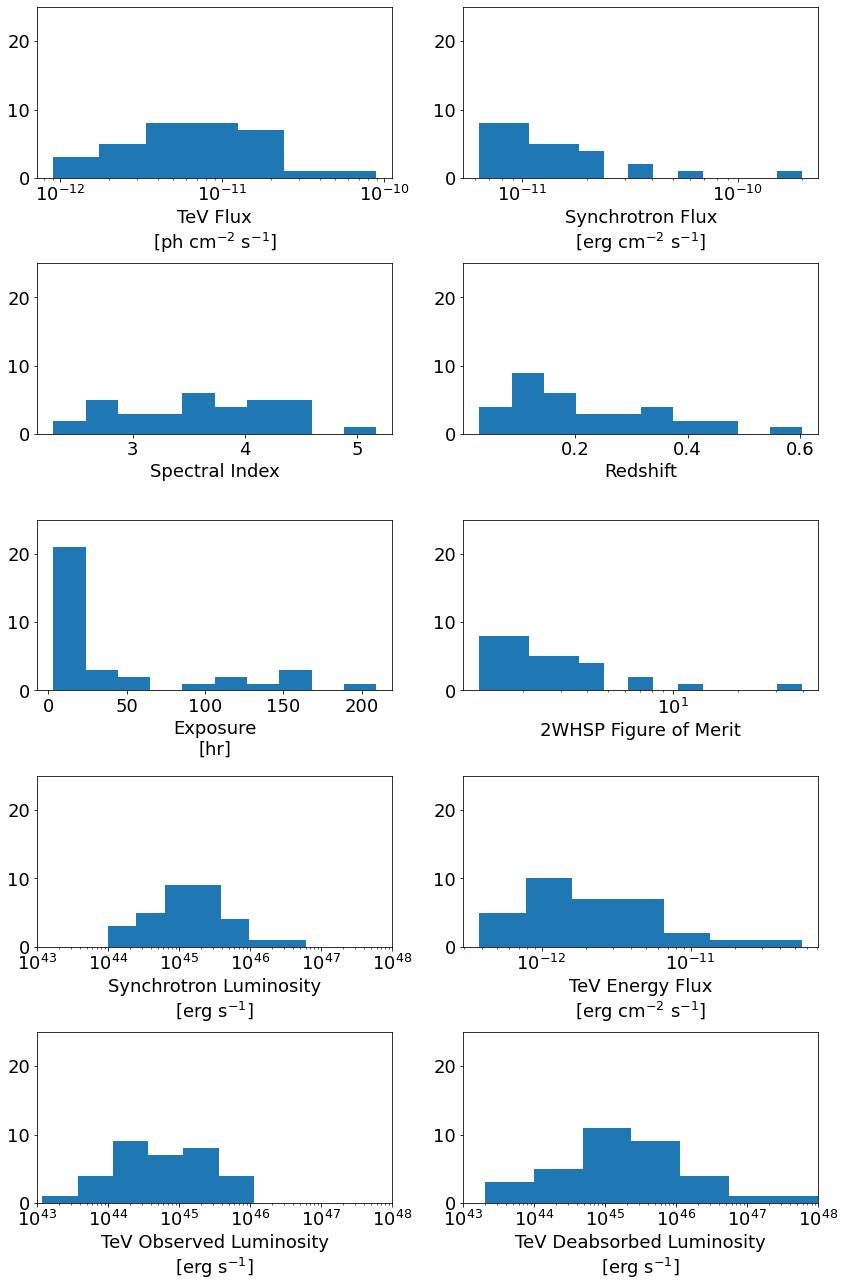

In [16]:
# dataset = 'archival', year1', 'legacy', or 'legacy-plus'
np.random.seed(0)
data, labels, value = generate_data(raw_data, dataset='year1')

for key in ['obs_luminosity', 'deabs_luminosity', 'z']:
    print("Min/max {}: {:.04}, {:.04}".format(key, np.min(value(key)), np.max(value(key))))
mean_exposure = np.mean(value('exposure'))
print("Mean exposure: {:.04}".format(mean_exposure))
mean_index = np.mean(value('index')).reshape(1)
print("Mean index: {:.04}".format(mean_index[0]))

# Plot distributions of the data
fig, axes = plt.subplots(5, 2, figsize=(14.0, 22.0))
for ax, (key, arr), label in zip(axes.ravel(), data.iteritems(), labels.values()):
    if key in ['index', 'z', 'exposure']:
        bins = 10
    else:
        _, bins = np.histogram(np.log10(arr), bins='auto')
        bins = 10**bins
        ax.set_xscale('log')
    ax.hist(arr, bins=bins)
    if key in ['whsp_luminosity', 'obs_luminosity', 'deabs_luminosity']:
        ax.set_xlim(1e43, 1e48)
    ax.set_ylim(0, 25)
    ax.set_xlabel(label)
plt.subplots_adjust(hspace=0.5)

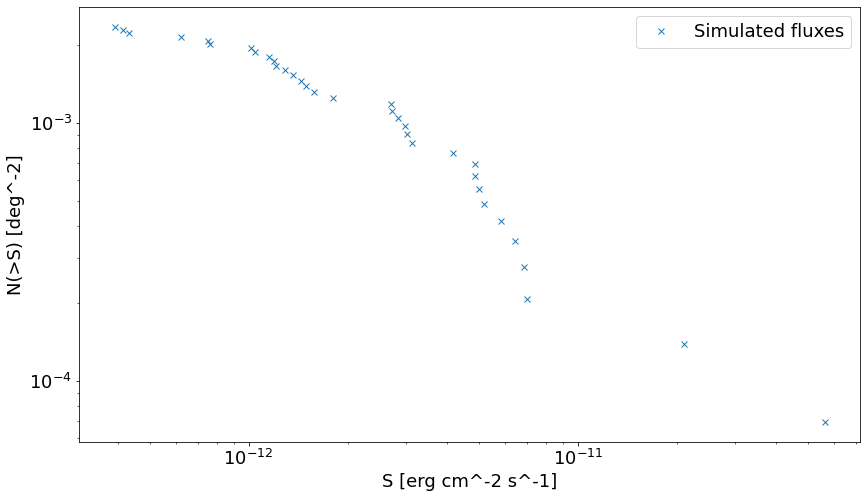

In [15]:
# Plot the logN-logS of the VERITAS sources (using the TeVCat fluxes)
logN_logS(value('tev_eflux'), sky_coverage_const=sky_coverage_const, label="Simulated fluxes")

In [17]:
def limiting_eflux_to_redshift(eflux, luminosity, index):
    num_zs = 250
    zs = np.linspace(0.0, 0.02*num_zs, num_zs)
    efluxes = np.zeros((len(luminosity), num_zs)) * eflux.unit
    for i, z in enumerate(zs):
        efluxes[:, i] = luminosity_to_eflux(luminosity, index, z)
    differences = np.abs(efluxes - np.expand_dims(eflux, axis=1))
    return zs[np.nanargmin(differences, axis=1)].flatten()*u.dimensionless_unscaled


def limiting_spectrum_to_redshift(spectrum, bin_edges, luminosity, index):
    num_zs = 125
    zs = np.linspace(0.0, 0.01*num_zs, num_zs)
    luminosities = np.zeros((len(luminosity), num_zs)) * luminosity.unit
    for i, z in enumerate(zs):
        luminosities[:, i] = spectrum_to_luminosity(spectrum, bin_edges, index, z,
                                                    deabsorb=True).to(luminosity.unit)
    differences = np.abs(luminosities - np.expand_dims(luminosity, axis=1))
    limiting_redshift = np.zeros(luminosity.shape)
    good = ~np.isnan(np.nanmin(differences, axis=1))
    limiting_redshift[good] = zs[np.nanargmin(differences[good], axis=1)].flatten()*u.dimensionless_unscaled
    return limiting_redshift

29/34 sources detected.
Redshift: [0.08       0.46140794 0.139      0.42982382 0.33054321 0.38503655
 0.12       0.203      0.137      0.198      0.19       0.278
 0.35       0.03       0.2        0.3        0.138      0.143
 0.33       0.18       0.13       0.135      0.31       0.604
 0.443      0.129      0.16       0.24       0.344      0.235
 0.03       0.055      0.18       0.119     ]
TeV Limiting Redshift: [0.05040323 0.44354839 0.14112903 0.49395161 0.34274194 0.41330645
 0.21169355 0.29233871 0.14112903 0.24193548 0.22177419 0.21169355
 0.34274194 0.10080645 0.32258065 0.32258065 0.18145161 0.21169355
 0.28225806 0.34274194 0.18145161 0.18145161 0.33266129 0.64516129
 0.53427419 0.17137097 0.21169355 0.25201613 0.37298387 0.28225806
 0.1108871  0.09072581 0.18145161 0.18145161]
2WHSP Limiting Redshift: [0.24096386 1.56626506 0.46184739 1.10441767 1.04417671 1.08433735
 0.54216867 0.80321285 0.562249   0.54216867 0.68273092 0.88353414
 1.10441767 0.42168675 0.86345382 1.044176

/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-11-9e4095a6950b>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


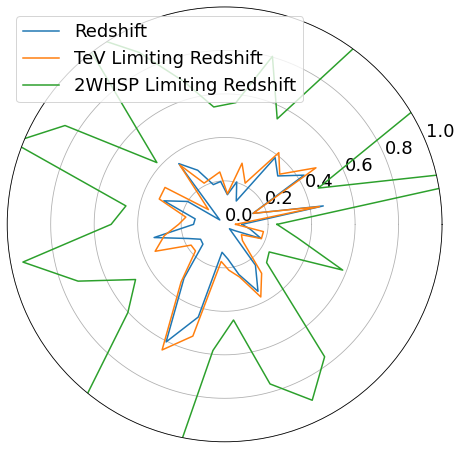

In [18]:
# Compare the limiting redshifts from the actual VERITAS observations
# to those from the selection flux limit

def calculate_limiting_redshifts(value, min_nu_f_nu=min_nu_f_nu, synchrotron_peak_index=synchrotron_peak_index,
                                 e_min=e_min, num_bins=num_bins):
    limiting_whsp_fluxes = np.ones(value('whsp_luminosity').size) * min_nu_f_nu
    limiting_whsp_z = limiting_eflux_to_redshift(limiting_whsp_fluxes, value('whsp_luminosity'),
                                                 synchrotron_peak_index)
    limiting_vts_fluxes = irf.sensitivity(value('exposure'))
    limiting_vts_spectra, limiting_vts_bin_edges = get_spectrum(limiting_vts_fluxes, value('index'),
                                                                e_min=e_min, e_max=u.TeV/(3*value('z')),
                                                                num_bins=num_bins)
    limiting_tev_z = limiting_spectrum_to_redshift(limiting_vts_spectra, limiting_vts_bin_edges,
                                                   value('deabs_luminosity'), value('index'))
    
    zs = {
        "Redshift": value('z'),
        "TeV Limiting Redshift": limiting_tev_z,
        "2WHSP Limiting Redshift": limiting_whsp_z
    }

    min_z = np.minimum(limiting_whsp_z, limiting_tev_z)
    detected = value('z') < min_z
    print("{}/{} sources detected.".format(sum(detected), len(min_z)))
    
    return zs, min_z, detected

zs, min_z, detected = calculate_limiting_redshifts(value)

ax = plt.subplot(111, polar=True)
for label, arr in zs.items():
    print("{}: {}".format(label, arr))
    polar_x = (2*np.pi / arr.size)*np.arange(arr.size + 1)
    ax.plot(polar_x, np.append(arr, arr[0]), label=label)
ax.set_xticks([])
ax.set_yticks(np.arange(0, 1.1, step=0.2))
ax.set_ylim((0, 1.0))
ax.legend()

In [18]:
# Define LF functional forms to test different models, following a simplified version of Ajello et al. (2014)
# The following simplifications are made:
#   Omit dependence on the spectral index 
#   Use a single power law corresponding to the lower-luminosity region instead of a smoothly broken power law
#   Test only PLE and PDE models, not LDDE


@njit
def lf_smoothly_broken_pl_base(log10_L, *args):
    log_A, index_1, log_L_break, index_2 = args
    A, L_break = np.exp(log_A), np.exp(log_L_break)
    L = 10**(log10_L - 46)
    return A / np.log(10) / L / ((L/L_break)**index_1 + (L/L_break)**index_2)


@njit
def lf_pl_base(log10_L, *args):
    log_A, index = args
    A = np.exp(log_A)
    L = 10**(log10_L - 46)  # L_scale = 1e46 erg/s
    return A / np.log(10) * np.power(L, -index - 1)


def evolution_factor_factory(evolution_params, fixed_xi=-0.3):
    
    evolution_param_dict = {
        'none': (False, False, False),
        'k': (True, False, False),
        'k_xi': (True, True, False),
        'k_tau': (True, False, True),
        'k_xi_tau': (True, True, True),
    }
    use_k, use_xi, use_tau = evolution_param_dict[evolution_params]
        
    @njit
    def evolution_factor(log10_L, z, *args):
        if use_k and use_tau:
            k_term = np.power(1 + z, args[0] + args[int(use_xi) + 1]*(log10_L - 46))
        elif use_k:
            k_term = np.power(1 + z, args[0])
        else:
            k_term = 1
        if use_xi:
            exp_term = np.exp(z/args[int(use_k)])
        else:
            exp_term = 1
        return k_term * exp_term
    
    return evolution_factor


def model_factory(base_model, evolution_model, evolution_params, split_idx):
    
    base_models = {
        'power_law': lf_pl_base,
        'smoothly_broken_power_law': lf_smoothly_broken_pl_base,
    }
    base_fn = base_models[base_model]
    evolution_factor = evolution_factor_factory(evolution_params)
    
    def model(log10_L, z, *args):
        base_args, evolution_args = args[:split_idx], args[split_idx:]
        if evolution_model == "pde":  # pure density evolution
            return base_fn(log10_L, *base_args) * evolution_factor(log10_L, z, *evolution_args)
        elif evolution_model == "ple":  # pure luminosity evolution
            return base_fn(log10_L - np.log10(evolution_factor(log10_L, z, *evolution_args)), *base_args)
        else:
            raise ValueError("unknown evolution {}".format(evolution))
        
    return model

In [19]:
# Define model-independent functions used for the optimization & fitting

# To construct the sky coverage, need to assume a standard spectral index (since the dependence was omitted)
# and constant exposure for every source
# Future work could derive from VERITAS observations an exposure probability distribution as a function of L, z
def detectable_volume_factory(zs, assumed_exposure, assumed_index, deabsorb=True, cutoff_exponent=10):
    """Precompute sky coverage function and comoving volume as a function of z"""
    assumed_limiting_flux = irf.sensitivity(assumed_exposure)
    limiting_spectrum, limiting_bin_edges = get_spectrum(assumed_limiting_flux, assumed_index, e_min=e_min,
                                                         e_max=u.TeV/(3*zs))
    limiting_luminosities = spectrum_to_luminosity(limiting_spectrum, limiting_bin_edges, assumed_index, zs,
                                                   deabsorb=deabsorb).value
    np.nan_to_num(limiting_luminosities, nan=np.inf, copy=False)
    comoving_volumes = cosmo.differential_comoving_volume(zs).value
    
    @njit
    def detectable_volume(L, z):
        limiting_luminosity = np.interp(z, zs, limiting_luminosities)
        sky_coverage = sky_coverage_const / (1 + (limiting_luminosity/L)**cutoff_exponent)
        comoving_volume = np.interp(z, zs, comoving_volumes)
        return 4*np.pi * sky_coverage * comoving_volume
    
    return detectable_volume


def poisson_lambda(log10_L, z, model, detectable_volume, *args):
    return model(log10_L, z, *args) * detectable_volume(10**log10_L, z)


@njit
def neg_log_prior(args, arg_limits):
    for arg, limits in zip(args, arg_limits):
        if not limits[0] < arg < limits[1]:
            return np.inf
    return 0


def neg_log_likelihood_factory(model, assumed_exposure, assumed_index, ranges, arg_limits):
        
    limiting_zs = np.logspace(-2, 0, 400)
    detectable_volume = detectable_volume_factory(limiting_zs, assumed_exposure, assumed_index)
    
    def neg_log_likelihood(args, log10_Ls, zs):
        poisson_lambda_args = (model, detectable_volume) + tuple(args)
        term_1 = -2*np.sum(np.log(model(log10_Ls, zs, *args) * cosmo.differential_comoving_volume(zs).value))
        term_2 = 2*integrate.nquad(poisson_lambda, ranges, args=poisson_lambda_args, opts={'epsabs': np.inf})[0]
        lp = neg_log_prior(args, arg_limits)
        return np.nan_to_num(lp + term_1 + term_2, nan=np.inf)
                
    return neg_log_likelihood

In [20]:
luminosity_type = 'deabs_luminosity'  # 'deabs_luminosity' or 'obs_luminosity'
args = (np.log10(value(luminosity_type).value[detected]), value('z').value[detected])
integration_ranges = tuple((np.min(arg), np.max(arg)) for arg in args)

# Parameter name, initial value, transform to apply, corresponding reverse transform
Param = namedtuple('Param', ['name', 'unit', 'initial_value', 'limits', 'forward_transform', 'reverse_transform'])
pl_params = [Param('A', u.Mpc**-3 * u.s/u.erg, 1e-12, (0, 1), np.log, np.exp),
             Param('alpha', u.dimensionless_unscaled, 0, (-.999, 10), lambda x: x, lambda x: x)]
smoothly_broken_pl_params = [Param('L_break', u.erg/u.s, 1e47, (1e40, 1e50), lambda x: np.log(x / 1e46),
                                   lambda x: 1e46*np.exp(x)),
                             Param('beta', u.dimensionless_unscaled, 0, (-.999, 10), lambda x: x, lambda x: x)]
k_param = Param('k', u.dimensionless_unscaled, 0, (-100, 100), lambda x: x, lambda x: x)
xi_param = Param('xi', u.dimensionless_unscaled, 0, (-10, 10), lambda x: x, lambda x :x)
tau_param = Param('tau', u.dimensionless_unscaled, 0, (-100, 100), lambda x: x, lambda x: x)


def define_params(base_model, evolution_params):
    bases = {
        'power_law': pl_params,
        'smoothly_broken_power_law': pl_params + smoothly_broken_pl_params,
    }
    evolutions = {
        'none': [],
        'k': [k_param],
        'k_xi': [k_param, xi_param],
        'k_tau': [k_param, tau_param],
        'k_xi_tau': [k_param, xi_param, tau_param],
    }
    params = bases[base_model] + evolutions[evolution_params]
    split_idx = len(bases[base_model])
    return params, split_idx

In [21]:
# Specify the model and fit it using maximum likelihood optimization

base_model = "power_law"
evolution_model = "ple"
evolution_params = "k"

params, param_split_idx = define_params(base_model, evolution_params)
initial_params = tuple(param.forward_transform(param.initial_value) for param in params)
param_limits = np.array([param.forward_transform(param.limits) for param in params])
model = model_factory(base_model, evolution_model, evolution_params, param_split_idx)

neg_log_likelihood = neg_log_likelihood_factory(model, mean_exposure, mean_index, integration_ranges,
                                                param_limits)
res = optimize.minimize(neg_log_likelihood, initial_params, args=args, method='Powell')
best_fit_params = {param.name: param.reverse_transform(final_val) for param, final_val in zip(params, res.x)}

print("Base model: {}".format(base_model))
print("Evolution model: {}".format(evolution_model))
print("Evolution parameters: {}".format(evolution_params.replace('_', ', ')))

print(res)
print("\nLog likelihood: {:.05}".format(res.fun))
for name, best_fit_val in best_fit_params.items():
    print("{}: {:.05}".format(name, best_fit_val))
print("")

<ipython-input-21-0e4d10b49a28>:9: RuntimeWarning: divide by zero encountered in log
  param_limits = np.array([param.forward_transform(param.limits) for param in params])
<ipython-input-11-9e4095a6950b>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/scipy/optimize/optimize.py:2115: RuntimeWarning: overflow encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: overflow encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/scipy/optimize/opt

Base model: power_law
Evolution model: ple
Evolution parameters: k
   direc: array([[ 0.32540289, -0.08582926, -1.01426109],
       [ 0.39155728, -0.0328565 , -2.15333372],
       [ 0.09431922, -0.02137113, -0.68475549]])
     fun: -65.25934253628887
 message: 'Optimization terminated successfully.'
    nfev: 303
     nit: 8
  status: 0
 success: True
       x: array([-18.94656738,  -0.361782  ,  -4.25923085])

Log likelihood: -65.259
A: 5.9103e-09
alpha: -0.36178
k: -4.2592



<ipython-input-11-9e4095a6950b>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


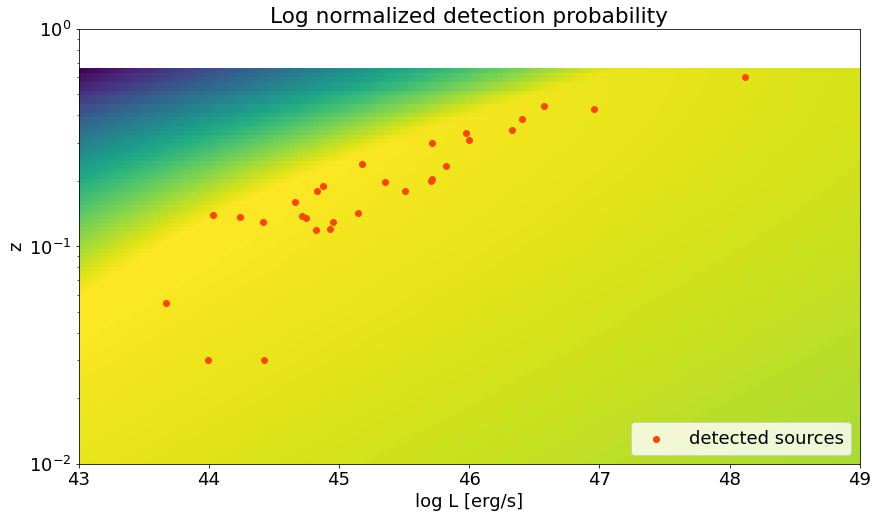

In [22]:
log10_Ls = np.linspace(43, 49, 200)
zs = np.logspace(-2, 0, 100)
ll, zz = np.meshgrid(log10_Ls, zs)

limiting_zs = np.logspace(-2, 0, 200)
detectable_volume = detectable_volume_factory(limiting_zs, mean_exposure, mean_index)
poisson_lambdas = poisson_lambda(ll.flatten(), zz.flatten(), model, detectable_volume, *res.x)
poisson_lambdas = poisson_lambdas.reshape(ll.shape)

plt.pcolormesh(log10_Ls, zs, poisson_lambdas, norm=mpl.colors.LogNorm())
plt.title("Log normalized detection probability")
plt.xlabel("log L [erg/s]")
plt.yscale('log')
plt.ylabel("z")
plt.scatter(*args, color='orangered', label="detected sources")
plt.legend(loc="lower right")

In [23]:
# Estimate the errors on the model parameters using Monte Carlo simulations

# Initialize the walkers around the ML best fit
ndim, nwalkers = len(initial_params), 6
p0 = np.array(initial_params) + 1e-4 * np.random.randn(nwalkers, ndim)

def log_likelihood(args, log10_Ls, zs):
    return -neg_log_likelihood(args, log10_Ls, zs)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=args)

sampler.run_mcmc(p0, 1000)

State([[-18.33427109  -0.43533525  -7.83652727]
 [-18.57410729  -0.45693592  -7.05527524]
 [-18.81065263  -0.39585225  -5.3797474 ]
 [-20.12695566  -0.20396324   1.77501764]
 [-18.92215938  -0.31488554  -5.88328737]
 [-18.85284264  -0.41039753  -4.05818124]], log_prob=[63.94573741 64.54395902 65.17474286 63.27470088 63.39307247 64.46517379], blobs=None, random_state=('MT19937', array([ 390457692, 2275005180, 4132890270, 4023583749, 3896265176,
       2671567588, 1690574196, 3682966835,  812171147, 2711183160,
       2374871861, 3699716918, 1742572201, 2915683832, 1330078441,
       1201327473, 3197083887, 3456338438, 2061753871,  241894901,
        595953758, 3717436726,  744529918, 1313072377,  996764053,
       4104781766,  809064021,  849615499, 2679134596, 3235777425,
       3587000549, 3497058719, 3485832450, 2861778949,  857047671,
       3164438279,  633070925, 2169876685, 1233787912, 1342999637,
       2466379513, 1198016855, 2089564661,   93048091,  453500751,
        17260898

N/50 = 20;
tau: [118.50767351  26.42622473  89.56697262]


Mean acceptance fraction: 0.611
Mean autocorrelation time: 78.167 steps


Text(0.5, 0, 'step number')

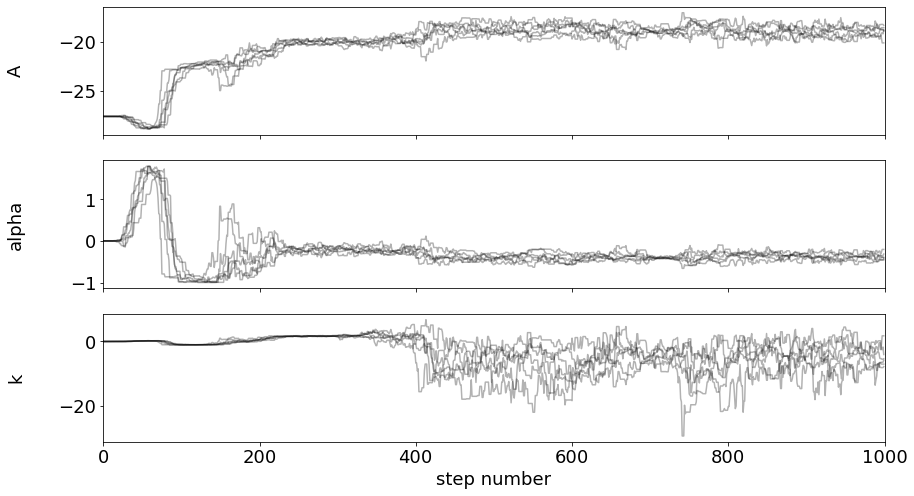

In [24]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time(quiet=True))))

all_samples = sampler.get_chain()

fig, axes = plt.subplots(ndim, sharex=True)
param_labels = [param.name for param in params]
for i, ax in enumerate(axes):
    ax.plot(all_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(all_samples))
    ax.set_ylabel(param_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [25]:
flat_samples = sampler.get_chain(discard=400, flat=True)
plot_samples = np.zeros(flat_samples.shape)
for i, param in enumerate(params):
    plot_samples[:, i] = param.reverse_transform(flat_samples[:, i])

A = 6.238e-09 + 2.749e-09 - 5.532e-09 s / (erg Mpc3)
alpha = -0.3864 + 0.08823 - 0.09426 
k = -5.177 + 5.391 - 4.039 


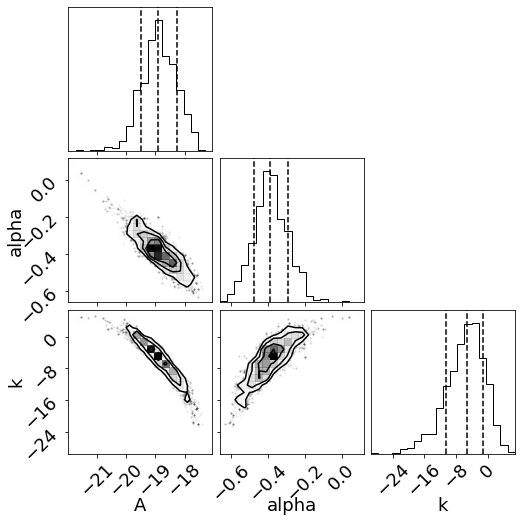

In [26]:
fig = corner.corner(flat_samples, quantiles=[0.16, 0.5, 0.84], labels=param_labels)

for i, param in enumerate(params):
    lower, median, upper = np.percentile(flat_samples[:, i], [16, 50, 84])
    tfm = param.reverse_transform
    lower, median, upper = tfm(lower), tfm(median), tfm(upper)
    lower_err, upper_err = np.diff((lower, median, upper))
    print("{} = {:.04} + {:.04} - {:.04} {}".format(param.name, median, lower_err, upper_err, param.unit))

<V/V_max> = 0.504 +- 0.054


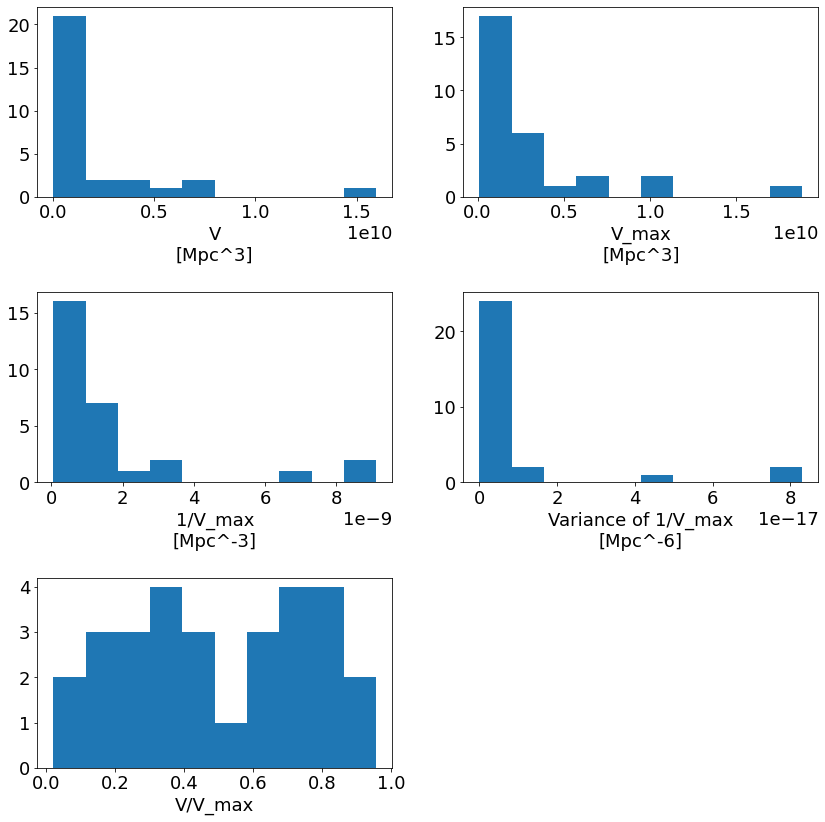

In [27]:
# Calculate V and V_max for each detected source,
# and perform a model-independent test for evolution using the V/V_max test

v = cosmo.comoving_volume(value('z').value[detected]) * sky_coverage_const
v_max = cosmo.comoving_volume(min_z.value[detected]) * sky_coverage_const
inverse_v_max = 1 / v_max
inverse_v_max_var = 1 / v_max**2
v_over_v_max = v / v_max

volumes = {
    "V\n[Mpc^3]": v,
    "V_max\n[Mpc^3]": v_max,
    "1/V_max\n[Mpc^-3]": inverse_v_max,
    "Variance of 1/V_max\n[Mpc^-6]": inverse_v_max_var,
    "V/V_max": v_over_v_max,
}

print("<V/V_max> = {:.3f} +- {:.3f}".format(np.mean(v_over_v_max), np.sqrt(1/(12*sum(detected)))))

fig, axes = plt.subplots(3, 2, figsize=(14.0, 14.0))
for ax, (label, arr) in zip(axes.ravel(), volumes.items()):
    ax.hist(arr.value)
    ax.set_xlabel(label)
axes[-1, -1].set_axis_off()
plt.subplots_adjust(hspace=0.5)

In [28]:
# Calculate density-weighted V_max to account for evolution 

def weighted_v_max(z_max, log10_L, evolution_args, evolution_factor, z_min=0):
        
    def integrand(z, *args):
        log10_L, z_min, *evolution_args = args
        norm = evolution_factor(log10_L, z_min, *evolution_args)
        return detectable_volume(10**log10_L, z) * evolution_factor(log10_L, z, *evolution_args) / norm
    
    v_max = integrate.quad(integrand, z_min, z_max, args=tuple([log10_L, z_min, *evolution_args]),
                           epsabs=np.inf)[0]
    return v_max


def calculate_lf_v_max(luminosity, z, evolution_params, evolution_param_values, luminosity_bins):
    weight_args = [z.value[detected], np.log10(luminosity.value)]
    evolution_factor = evolution_factor_factory(evolution_params)
    weighted_v_maxes = np.array([weighted_v_max(z_max, log10_L, evolution_param_values, evolution_factor)
                                 for z_max, log10_L in zip(*weight_args)])*u.Mpc**3
    weighted_density = 1 / weighted_v_maxes
    
    bin_idxs = np.digitize(luminosity.value, luminosity_bins) - 1
    pts, pt_errs = [], []
    for i, lum_bin in enumerate(luminosity_bins[:-1]):
        bin_size = np.log(luminosity_bins[i + 1]) - np.log(luminosity_bins[i])
        pts.append(np.sum(weighted_density[bin_idxs == i].value) / bin_size)
        pt_errs.append(np.sqrt(np.sum(weighted_density[bin_idxs == i].value**2)) / bin_size)
    pts, pt_errs = np.array(pts), np.array(pt_errs)

    return pts, pt_errs

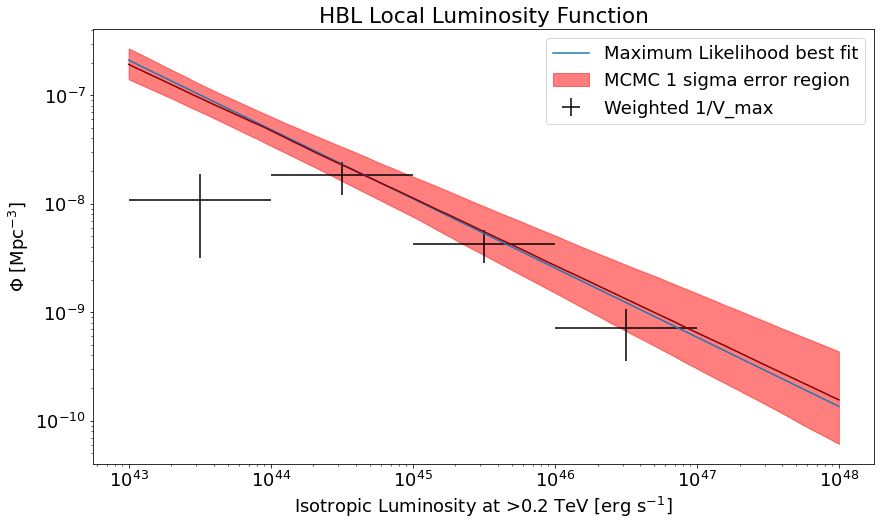

In [29]:
def plot_lf_v_max(bins, bin_errs, densities, density_errs, label=None):
    plt.errorbar(bins, densities, xerr=bin_errs, yerr=density_errs, label=label, linestyle='none', color='k')

    
def plot_lf_ml(luminosities, model, best_fit_params, label=None):
    plt.plot(luminosities, model(np.log10(luminosities), 0, *best_fit_params), label=label)
    

def plot_mcmc(luminosities, curves, label=None):
    # Plot 1 sigma confidence interval
    lo, med, hi = np.percentile(curves, (16, 50, 84), axis=0)
    plt.plot(luminosities, med, color='darkred')
    plt.fill_between(luminosities, lo, hi, color='red', alpha=0.5, label=label)


min_log10_L, max_log10_L = 43, 48
bins = np.logspace(min_log10_L, max_log10_L, max_log10_L - min_log10_L + 1)
bin_centers = stats.gmean(np.stack([bins[:-1], bins[1:]]), axis=0)
bin_errs = np.stack([bin_centers - bins[:-1], bins[1:] - bin_centers])
observed_luminosity = value(luminosity_type)[detected]
evolution_param_values = res.x[-(len(params) - param_split_idx):]
pts, pt_errs = calculate_lf_v_max(observed_luminosity, min_z, evolution_params, evolution_param_values, bins)
plot_lf_v_max(bin_centers, bin_errs, pts, pt_errs, label="Weighted 1/V_max")

luminosities = np.logspace(min_log10_L, max_log10_L, 100)
curves = []
for sample in flat_samples:
    curves.append(model(np.log10(luminosities), 0, *sample))

plot_lf_ml(luminosities, model, res.x, label="Maximum Likelihood best fit")
plot_mcmc(luminosities, curves, label="MCMC 1 sigma error region")

plt.title("HBL Local Luminosity Function")
plt.xscale('log')
plt.xlabel("Isotropic Luminosity at >{} TeV".format(e_min.to_value(u.TeV)) + " [erg s$^{-1}$]")
plt.yscale('log')
plt.ylabel("$\Phi$ [Mpc$^{-3}$]")
plt.legend()

In [30]:
def bootstrap(points, errors):
    """Use bootstrapping to calculate the overall mean and uncertainty of a sequence of measurements"""
    
    samples = np.random.normal(points, errors, (10000,) + points.shape)
    axis = tuple(range(0, samples.ndim - 1))
    lower, median, upper = np.percentile(samples, [16, 50, 84], axis=axis)
    lower_err, upper_err = np.diff((lower, median, upper), axis=0)
    return median, np.stack([lower_err, upper_err])

In [ ]:
# Estimate the effect of uncertaintities in the data by repeated sampling

num_data_samples = 16
dataset = 'archival'  # 'year1', 'legacy', or 'legacy-plus'
luminosity_type = 'deabs_luminosity'  # 'deabs_luminosity' or 'obs_luminosity'

curves = []
samples = []
v_over_v_max = []
v_over_v_max_err = []
density_pts = []
density_pt_errs = []
num_detected = []
min_detected_flux = []

num_samples_analyzed = 0
while num_samples_analyzed < num_data_samples:
    print("Analyzing sample {}...".format(num_samples_analyzed + 1))
    data, labels, value = generate_data(raw_data, dataset=dataset, seed=num_samples_analyzed)
    
    min_z, detected = calculate_limiting_redshifts(value)[1:]
        
    num_detected.append(sum(detected))
    min_detected_flux.append(np.min(value('flux')[detected].value))
    
    v = cosmo.comoving_volume(value('z').value[detected]) * sky_coverage_const
    v_max = cosmo.comoving_volume(min_z.value[detected]) * sky_coverage_const
    v_over_v_max.append([np.mean(v/v_max)])
    v_over_v_max_err.append([np.sqrt(1/(12*sum(detected)))])
    print("<V/V_max> = {:.3f} +- {:.3f}".format(v_over_v_max[-1][0], v_over_v_max_err[-1][0]))
    
    args = (np.log10(value(luminosity_type).value[detected]), value('z').value[detected])
    integration_ranges = tuple((np.min(arg), np.max(arg)) for arg in args)
    
    mean_exposure, mean_index = np.mean(value('exposure')), np.mean(value('index')).reshape(1)
    neg_log_likelihood = neg_log_likelihood_factory(model, mean_exposure, mean_index, integration_ranges,
                                                    param_limits)
    ndim, nwalkers = len(initial_params), 6
    p0 = np.array(initial_params) + 1e-4 * np.random.randn(nwalkers, ndim)

    def log_likelihood(args, log10_Ls, zs):
        return -neg_log_likelihood(args, log10_Ls, zs)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=args)
    print("Running MCMC...")
    sampler.run_mcmc(p0, 1000)
    data_sample_samples = sampler.get_chain(discard=400, flat=True)
    for sample in data_sample_samples:
        curves.append(model(np.log10(luminosities), 0, *sample))
        samples.append(sample)
    
    med_sample = np.percentile(data_sample_samples, 50, axis=0)
    evolution_param_values = med_sample[-(len(params) - param_split_idx):]
    observed_luminosity = value(luminosity_type)[detected]
    pts, pt_errs = calculate_lf_v_max(observed_luminosity, min_z, evolution_params, evolution_param_values, bins)
    density_pts.append(pts)
    density_pt_errs.append(pts)
    num_samples_analyzed += 1
    print("")

num_detected, min_detected_flux = np.array(num_detected), np.array(min_detected_flux)
samples = np.array(samples)
v_over_v_max, v_over_v_max_err = np.array(v_over_v_max), np.array(v_over_v_max_err)
density_pts, density_pt_errs = np.stack(density_pts), np.stack(density_pt_errs)

Analyzing sample 1...
Total LF exposure: 0.0 h
0/39 sources with zero simulated flux excluded from the analysis.


/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-11-9e4095a6950b>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


27/39 sources detected.
<V/V_max> = 0.531 +- 0.056
Running MCMC...

Analyzing sample 2...
Total LF exposure: 0.0 h
1/39 sources with zero simulated flux excluded from the analysis.


/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-11-9e4095a6950b>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


30/38 sources detected.
<V/V_max> = 0.557 +- 0.053
Running MCMC...

Analyzing sample 3...
Total LF exposure: 0.0 h
0/39 sources with zero simulated flux excluded from the analysis.


/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-11-9e4095a6950b>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


29/39 sources detected.
<V/V_max> = 0.497 +- 0.054
Running MCMC...

Analyzing sample 4...
Total LF exposure: 0.0 h
1/39 sources with zero simulated flux excluded from the analysis.
26/38 sources detected.
<V/V_max> = 0.535 +- 0.057
Running MCMC...


/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-11-9e4095a6950b>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [ ]:
luminosities = np.logspace(min_log10_L, max_log10_L, 100)
overall_density_pts, overall_density_pt_errs = bootstrap(density_pts, density_pt_errs)
overall_v_over_v_max, overall_v_over_v_max_err = bootstrap(v_over_v_max, v_over_v_max_err)
print("{:.03} +- {:.02} sources detected".format(np.mean(num_detected), np.std(num_detected)))
print("<V/V_max> = {:.3f} - {:.3f} + {:.3f}".format(overall_v_over_v_max[0], overall_v_over_v_max_err[0,0],
                                                    overall_v_over_v_max_err[1,0]))

plot_mcmc(luminosities, curves, label="MCMC 1 sigma error region")
plot_lf_v_max(bin_centers, bin_errs, overall_density_pts, overall_density_pt_errs, label="Weighted 1/V_max")

plt.title("HBL Local Luminosity Function ({} dataset)".format(dataset))
plt.xscale('log')
plt.xlabel("Isotropic Luminosity at >{} TeV".format(e_min.to_value(u.TeV)) + " [erg s$^{-1}$]")
plt.yscale('log')
plt.ylabel("$\Phi$ [Mpc$^{-3} (L/10^{46})^{-1}$]")
plt.legend()

In [ ]:
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels=param_labels)

for i, param in enumerate(params):
    lower, median, upper = np.percentile(samples[:, i], [16, 50, 84])
    tfm = param.reverse_transform
    lower, median, upper = tfm(lower), tfm(median), tfm(upper)
    lower_err, upper_err = np.diff((lower, median, upper))
    print("{} = {:.04} + {:.04} - {:.04} {}".format(param.name, median, lower_err, upper_err, param.unit))

    
hist_fig, axes = plt.subplots(1, 2, figsize=(14.0, 5.0))

axes[0].hist(num_detected)
axes[0].set_title("Number of detected sources")
axes[1].hist(min_detected_flux)
axes[1].set_title("Minimum detected flux [ph cm$^{-2}$ s$^{-1}$]")

Total LF exposure: 300.28 h
5/39 sources with zero simulated flux excluded from the analysis.
31/34 sources detected.


<ipython-input-11-9e4095a6950b>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))


(array([1., 1., 6., 6., 5., 4., 6., 0., 1., 0.]),
 array([9.29880788e-13, 1.46809630e-12, 2.31783124e-12, 3.65939322e-12,
        5.77745202e-12, 9.12144441e-12, 1.44009414e-11, 2.27362142e-11,
        3.58959474e-11, 5.66725414e-11, 8.94746394e-11]),
 <a list of 10 Patch objects>)

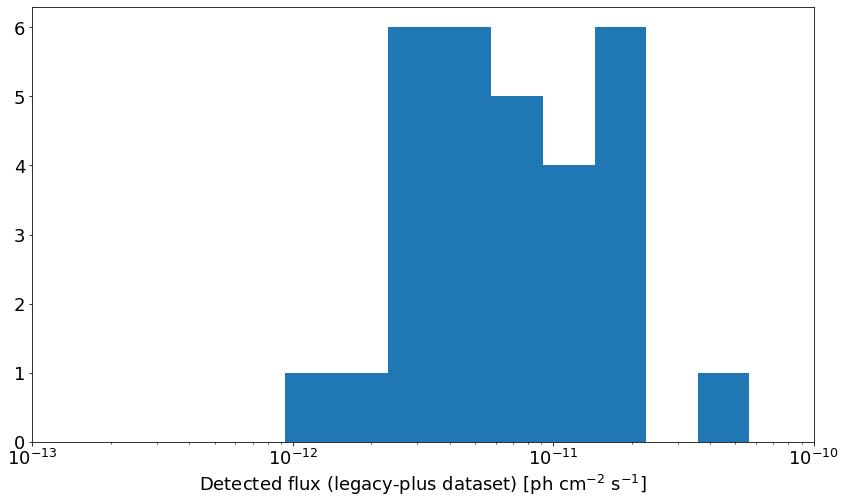

In [54]:
dataset = 'legacy-plus'
data, labels, value = generate_data(raw_data, dataset=dataset, seed=0)
min_z, detected = calculate_limiting_redshifts(value)[1:]
arr = value('flux')[detected].value
_, bins = np.histogram(np.log10(arr), bins=10)
bins = 10**bins
plt.xscale('log')
plt.xlim(1e-13, 1e-10)
plt.xlabel("Detected flux ({} dataset) ".format(dataset) + labels['flux'].split('\n')[1])
plt.hist(arr, bins=bins)

In [57]:
np.sum(raw_data.archival_hours.to_numpy()*0.7)*u.hr

<Quantity 1481.06 h>